<a href="https://colab.research.google.com/github/ako-precious/lstm/blob/main/stockprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

data = pd.read_csv('/content/AAPL.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099058,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093890,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086999,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089152,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091737,73449600


In [4]:
df = data[['Close','Date']]
df

,Close,Date
0,0.128348,1980-12-12
1,0.121652,1980-12-15
2,0.112723,1980-12-16
3,0.115513,1980-12-17
4,0.118862,1980-12-18
...,...,...
11001,209.270004,2024-08-05
11002,207.229996,2024-08-06
11003,209.820007,2024-08-07
11004,213.309998,2024-08-08


In [5]:
import datetime as dt
df['Date'] = pd.to_datetime(df['Date'])
df

<ipython-input-5-7045f165e21e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


,Close,Date
0,0.128348,1980-12-12
1,0.121652,1980-12-15
2,0.112723,1980-12-16
3,0.115513,1980-12-17
4,0.118862,1980-12-18
...,...,...
11001,209.270004,2024-08-05
11002,207.229996,2024-08-06
11003,209.820007,2024-08-07
11004,213.309998,2024-08-08


In [8]:
df.index = df.pop('Date')
df

,Close
Date,
1980-12-12,0.128348
1980-12-15,0.121652
1980-12-16,0.112723
1980-12-17,0.115513
1980-12-18,0.118862
...,...
2024-08-05,209.270004
2024-08-06,207.229996
2024-08-07,209.820007


<Axes: xlabel='Date'>

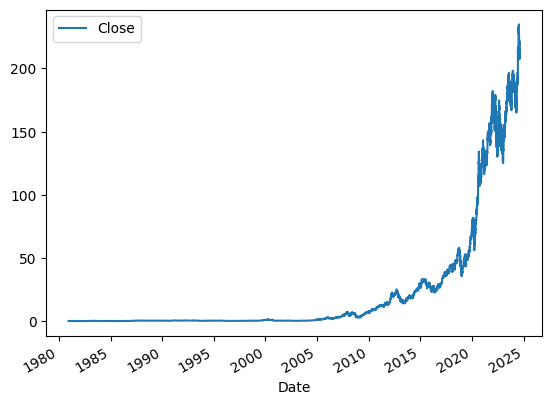

In [9]:
import matplotlib.pyplot as plt
df.plot()

In [27]:
import numpy as np
import pandas as pd
import datetime

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = pd.to_datetime(first_date_str)
    last_date  = pd.to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    while True:
        # Use .loc to slice by index values (dates)
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # Calculate the next date using the index
        next_date = target_date + pd.Timedelta(days=7)

        if last_time:
            break

        target_date = next_date

        if target_date >= last_date: # Use '>=' to include last_date
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '2021-01-18',
                                '2024-08-09',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-01-18,128.800003,130.889999,128.910004,127.139999
1,2021-01-25,132.029999,136.869995,139.070007,142.919998
2,2021-02-01,142.059998,137.089996,131.960007,134.139999
3,2021-02-08,133.940002,137.389999,136.759995,136.910004
4,2021-02-15,136.009995,135.389999,135.130005,135.369995
...,...,...,...,...,...
182,2024-07-15,232.979996,227.570007,230.539993,234.399994
183,2024-07-22,228.880005,224.179993,224.309998,223.960007
184,2024-07-29,218.539993,217.490005,217.960007,218.240005
185,2024-08-05,222.080002,218.360001,219.860001,209.270004


In [28]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((187,), (187, 3, 1), (187,))

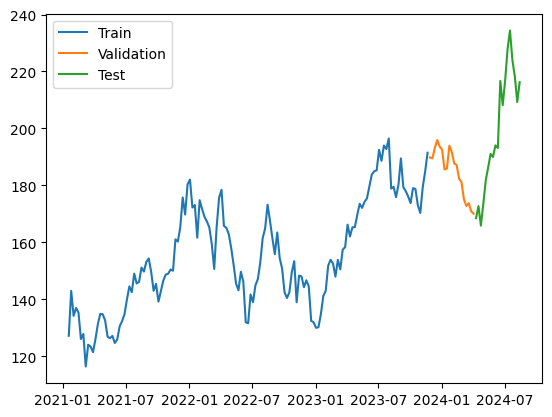

In [29]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 24431.3574 - mean_absolute_error: 155.0905 - val_loss: 33983.7148 - val_mean_absolute_error: 184.1587
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 24481.6680 - mean_absolute_error: 155.2774 - val_loss: 33823.7539 - val_mean_absolute_error: 183.7238
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 24494.2148 - mean_absolute_error: 155.2737 - val_loss: 33653.0156 - val_mean_absolute_error: 183.2585
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 23418.3477 - mean_absolute_error: 151.8309 - val_loss: 33467.2109 - val_mean_absolute_error: 182.7507
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 23796.4766 - mean_absolute_error: 153.0753 - val_loss: 33237.5664 - val_mean_absolute_error: 182.1211
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 23850.3730 - mean_absolute_error: 153.2385 - val_loss: 32917.9453 - val_mean_absolute_error: 181.2411
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


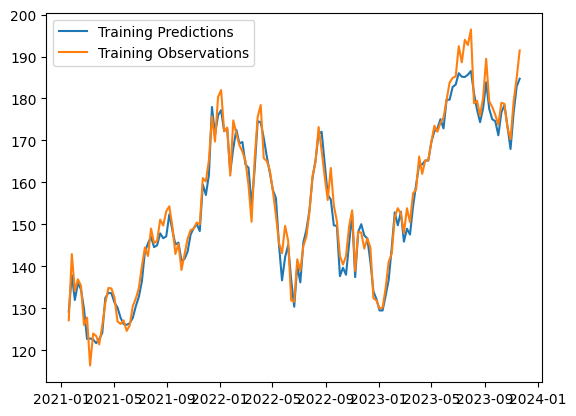

In [31]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


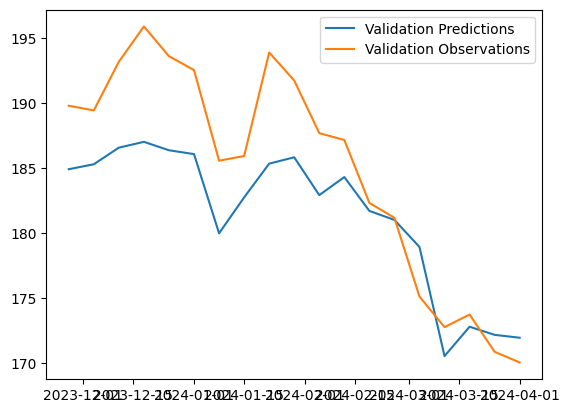

In [32]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


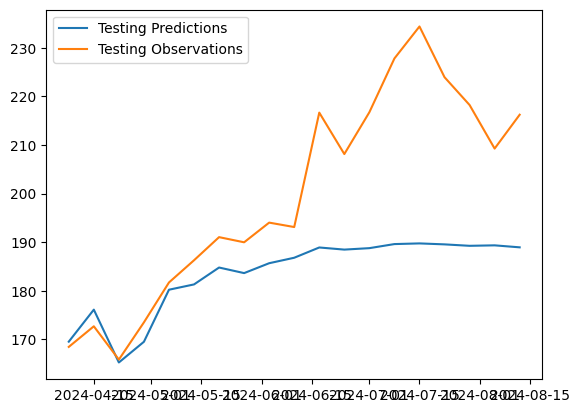

In [33]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

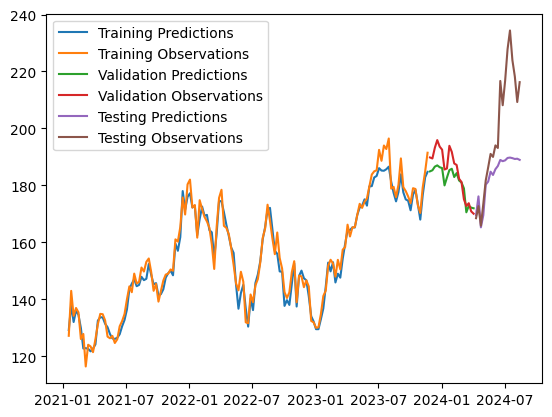

In [34]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [35]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

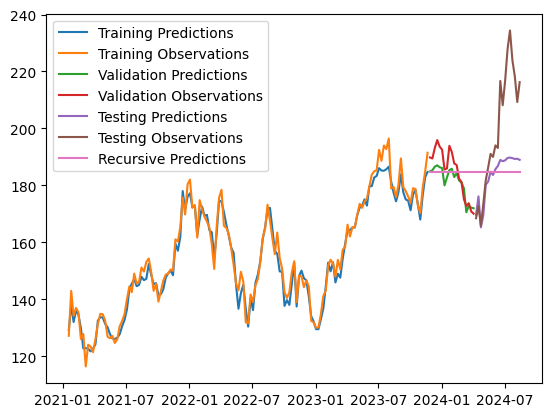

In [36]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])